# Segmentação de órgãos e estruturas fetais em exames ultrassonográficos



## Descrição:

Para esta aplicação foi utilizado o dataset presente [neste link](https://data.mendeley.com/datasets/4gcpm9dsc3/1), com por volta de 1500 imagens coletadas de 169 participantes que contribuíram com um número váriavel de imagens da circunferência do abdômen fetal (CA). As participantes elegíveis foram gestantes com idade igual ou superior a 18 anos, em trabalho de parto ou com parto programado na Maternidade do Hospital Universitário Polydoro Ernani de São Thiago, em Florianópolis, Santa Catarina, Brasil. 

Médicos especialistas usaram um protocolo de aquisição padronizado para obter imagens de ultrassom. Uma seção axial comum da CA fetal foi capturada, com medidas tomadas na parte mais larga do abdômen fetal, abrangendo o fígado. Esta seção abrangeu o estômago fetal, a artéria aorta, a coluna vertebral e a porção intra-hepática da veia umbilical.

As imagens  de ultrassom foram adquiridas usando uma variedade de dispositivos de ultrassom. Para o processo de anotação, foi empregado o software 3D Slicer para marcar e identificar cuidadosamente cada região de interesse e condição, como esteatose hepática e desequilíbrio metabólico. Depois que as imagens e anotações ficaram prontas, converteu-se as imagens de ultrassom para o formato PNG para facilitar a manipulação e análise. As anotações foram exportadas do 3D Slicer e salvas no formato .npy. Dentro de cada arquivo .npy, é incluído um dicionário que mapeia as estruturas anotadas para suas respectivas imagens. 

### Inicializações:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from sklearn.metrics import precision_score,recall_score
import pandas as pd
from modelo import load,evaluate,Model_cos,Model_2,Model,ORGAOS, colors,clean,create_reshape,transform,reduce, remove_black, conf_matrix # tirar model 2
from plot import img_with_labels, plot_pred
import seaborn as sns
import cv2
import random

In [9]:
def plot_images(data_ex, title, with_labels=False):
    print(title)
    plt.figure(figsize=(30, 30))
    for i in range(len(data_ex)):
        plt.subplot(5, 5, i + 1)
        img, structures = data_ex[i]
        if with_labels:
            img = img_with_labels(img, structures)
        plt.imshow(img, 'gray' if not with_labels else None)
        plt.axis("off")
    
    if with_labels:
        legend_patches = [mpatches.Patch(color=color, label=label) for label, color in zip(ORGAOS, [cor/255 for cor in list(colors.values())])]
        plt.legend(handles=legend_patches, loc='upper left', fontsize=18, bbox_to_anchor=(1.1, 1))
    
    plt.show()

### Visão geral do dataset:

1588 Imagens no total.

Exemplos de imagens cruas:


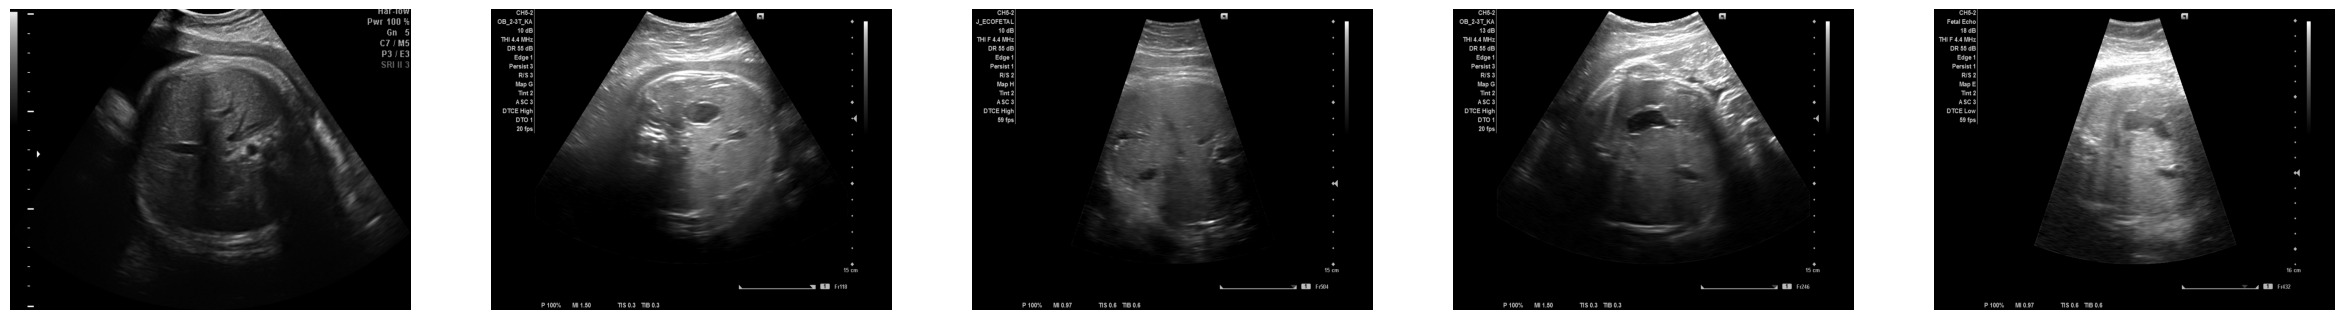

Exemplos de imagens com as anotações:


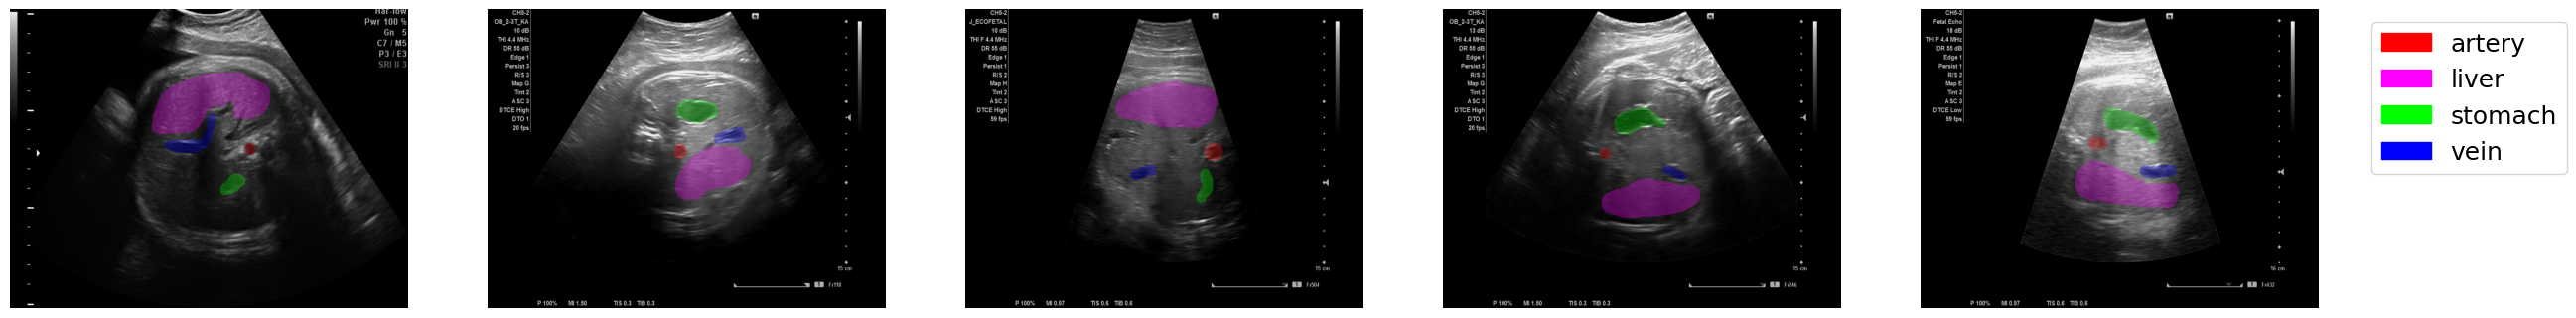

In [62]:
folder = 'ARRAY_FORMAT'
data_files = [os.path.join(folder,name) for name in os.listdir(folder)]
print(f"{len(data_files)} Imagens no total.\n")

data_ex = []

for i in range(5):
    img, structures = load(data_files[random.randint(0, len(data_files))]) 
    data_ex.append((img, structures))
    print('Files:',i,end = '\r')


plot_images(data_ex, "Exemplos de imagens cruas:")

plot_images(data_ex, "Exemplos de imagens com as anotações:", with_labels=True)



### Geração do modelo de classificação

A criação do modelo começa com a conversão das estruturas das imagens em vetores para facilitar o processo de clusterização. Esses vetores lineares são então agrupados utilizando o algoritmo K-Means, que organiza as imagens em 10 clusters com base nas similaridades de suas estruturas.

Para cada cluster identificado, é construído um modelo agregado das estruturas anatômicas. Esse modelo é gerado somando as estruturas escuras (artéria, estômago e veia) de todas as imagens pertencentes ao mesmo cluster, resultando em uma representação média das estruturas para aquele grupo específico. Além disso, templates detalhados para cada órgão (como artérias, fígado, estômago e veias) são criados dentro de cada cluster. Esses templates são gerados somando as estruturas correspondentes de cada órgão e, em seguida, normalizando pela quantidade de imagens no cluster.

Essa abordagem permite identificar padrões comuns entre as diferentes imagens e criar representações médias que refletem as características típicas das estruturas anatômicas presentes em cada grupo. Assim, o modelo final é composto por esses agregados médios e templates detalhados, proporcionando uma visão clara das variações estruturais e de representação de imagens entre os grupos.

Foram utilizados 2 métodos diferentes para a classificação de uma dada imagem dentro dos 10 clusters:

- **Cosseno de similaridade**: Para este método, as imagens template de cada classe têm fundo cinza e são subtraídas as estruturas escuras de cada elemento pertencente ao cluster e normalizado pelo número total dele. Isso gera imagens que devem naturalmente se parecer com as imagens que queremos processar.
- **Subtração simples normalizada**: Neste método, os templates começam em um fundo preto e as estruturas escuras são adicionadas e normalizadas. Isto é feito porque o template da classe será subtraído da imagem de interesse, reduzindo a soma total dos pixels do objeto de análise. No entanto, as zonas escuras dos órgãos artéria, estômago e veia que serão subtraídas de um valor e, caso a imagem template seja parecida com a imagem de análise, a soma dos pixels da imagem de subtração será semelhante à imagem em questão, pois as intensidades negativas dos pixels são mantidas em 0.


    

#### Templetes para o modelo que usa subtração para classificar:

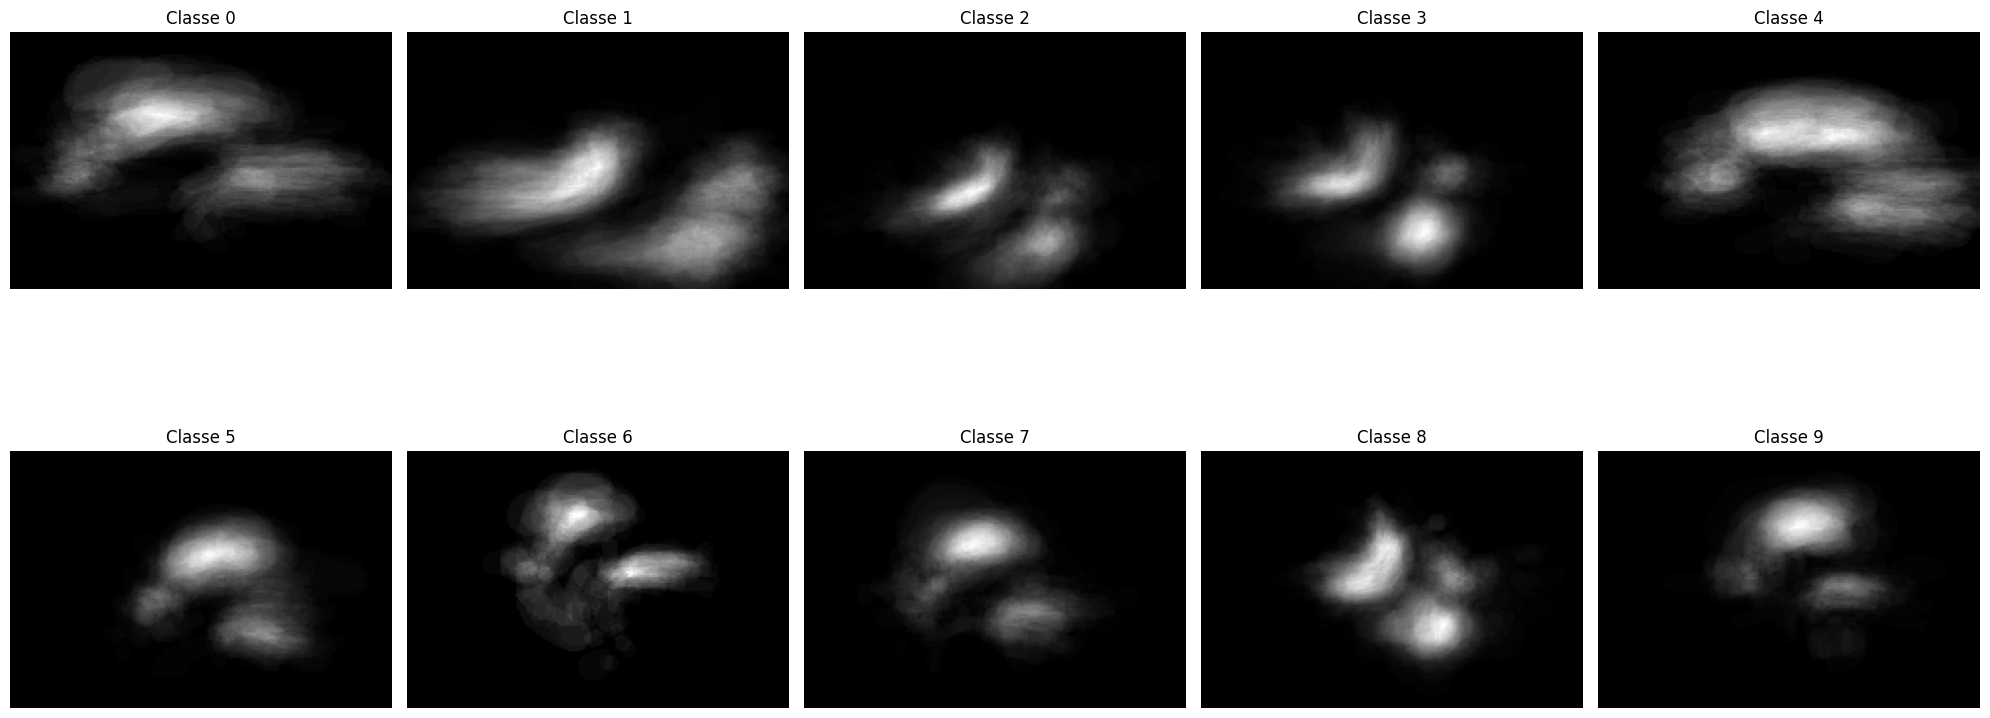

In [13]:
folder_class = 'MODEL/classes'
data_files_class = [os.path.join(folder_class,name) for name in sorted(os.listdir(folder_class))]


n = len(data_files_class)
num_rows = 2  
num_cols = n//num_rows


fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for img_idx, img_path in enumerate(data_files_class):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    class_number = img_path.split('/')[-1].split('.')[0]
    row_idx = img_idx // num_cols
    col_idx = img_idx % num_cols
    ax = axes[row_idx, col_idx]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Classe {class_number}', fontsize=12)


plt.tight_layout()
plt.show()

#### Templetes para o modelo que cosseno de similaridade

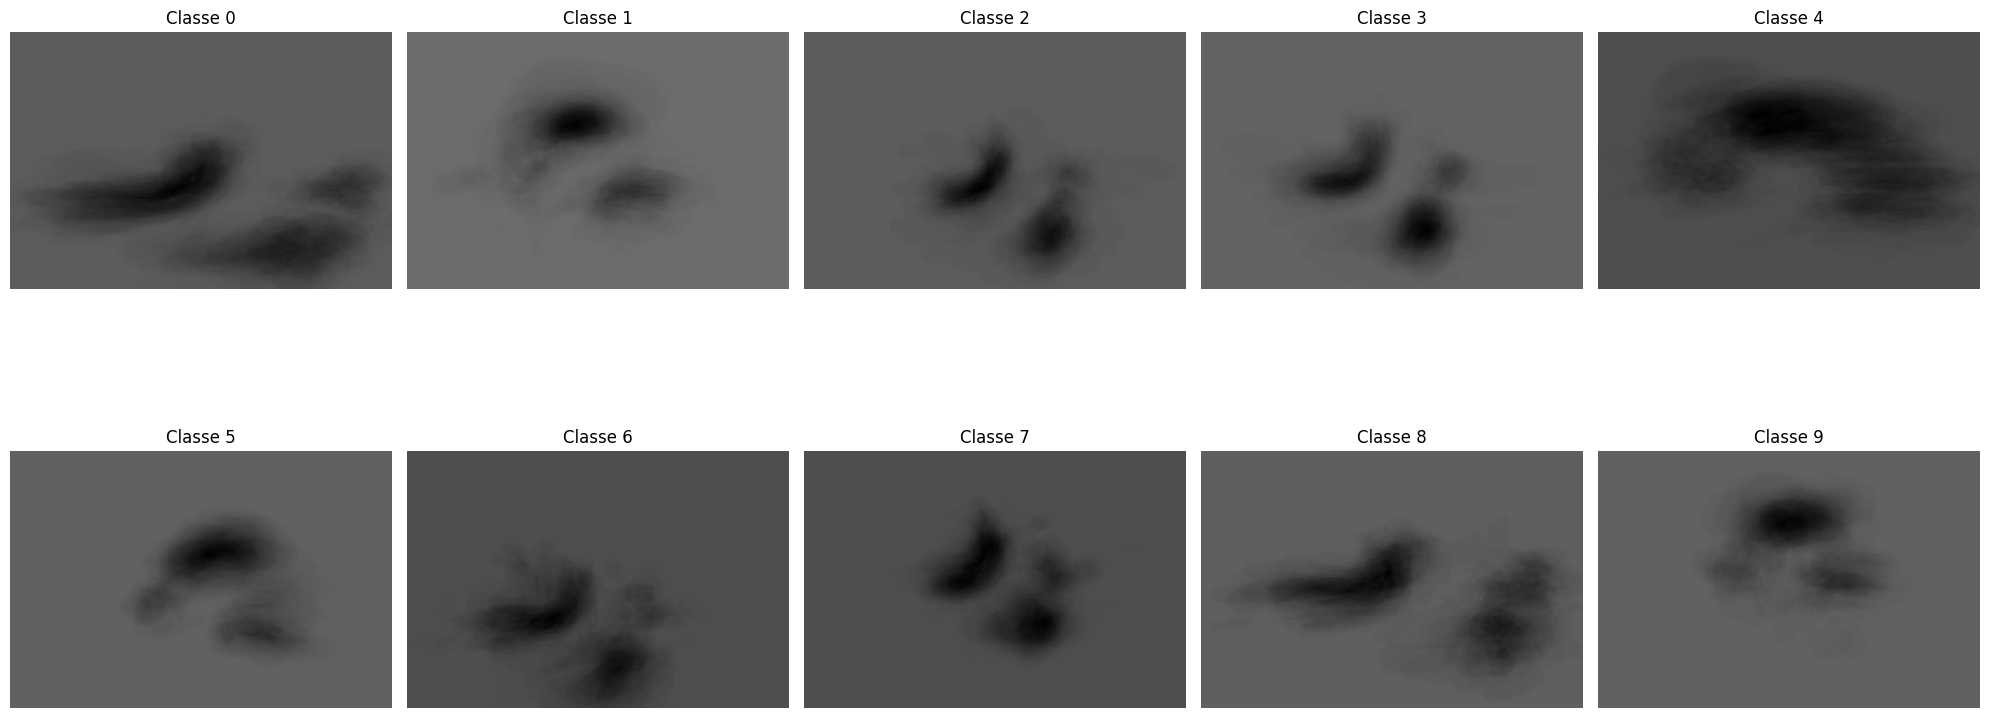

In [31]:
folder_class_c = 'MODEL_c/classes'
data_files_class_c = [os.path.join(folder_class_c,name) for name in sorted(os.listdir(folder_class_c))]


n = len(data_files_class_c)
num_rows = 2  
num_cols = n//num_rows


fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for img_idx, img_path in enumerate(data_files_class_c):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    class_number = img_path.split('/')[-1].split('.')[0]
    row_idx = img_idx // num_cols
    col_idx = img_idx % num_cols
    ax = axes[row_idx, col_idx]
    ax.imshow(img,vmax=255, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Classe {class_number}', fontsize=12)


plt.tight_layout()
plt.show()

### Pipeline de processamento:



#### Classificação:

**Passo 1**: Limpeza das imagens usando utilizando operações morfológicas de erosão e dilatação para processar a máscara e escolher a maior região conectada da imagem.

**Passo 2**: Para padronizar as imagens é feito o reshape.

**Passo 3**: É feita também a remoção das bordas da imagens e retirado o fundo preto.

**Passo 4**: É realizado o calculo de similiariade entre as imagens em questão e os templates de classes do modelo criado com o uso de K-means.

Imagens limpas:


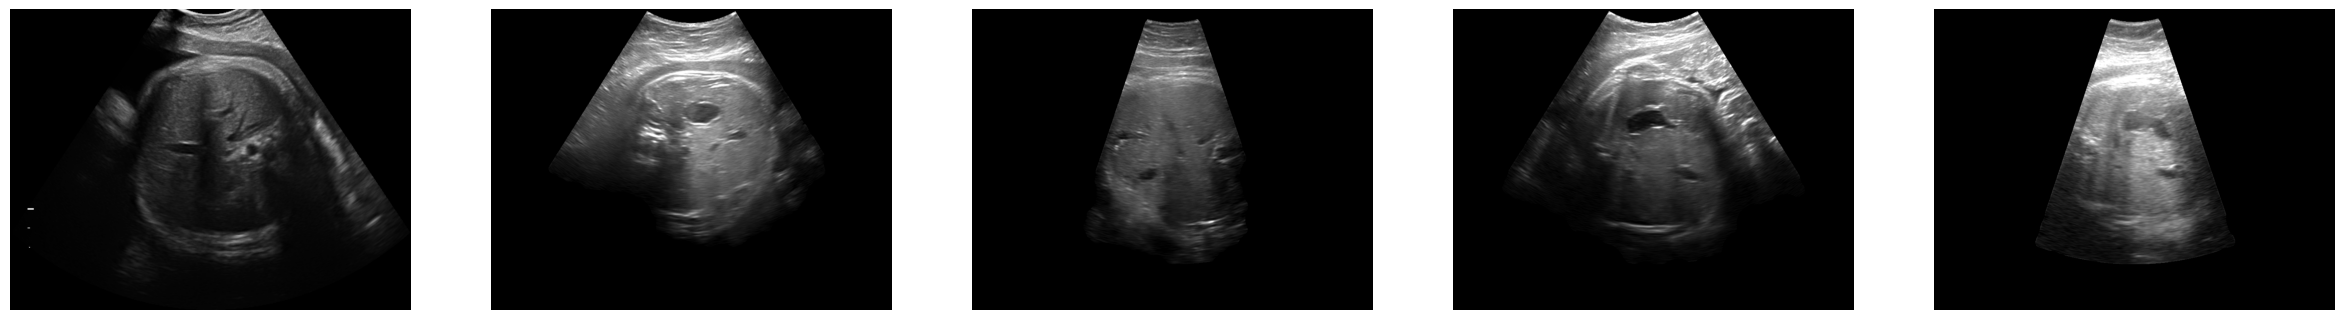

Imagens após reshape:


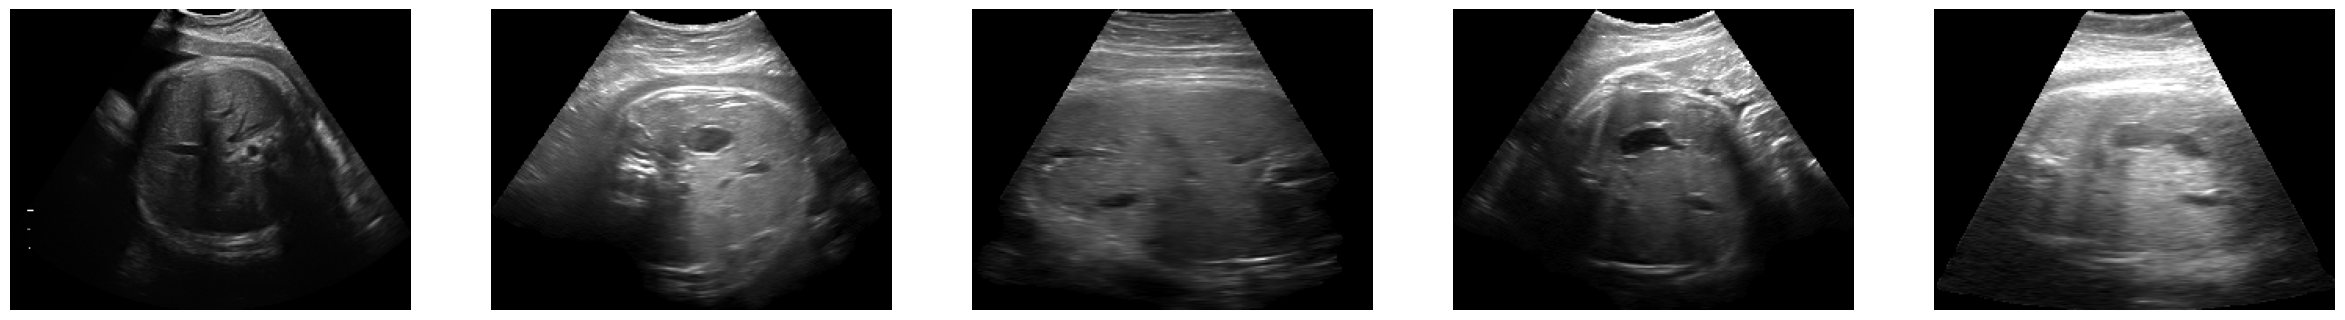

Após transformações:


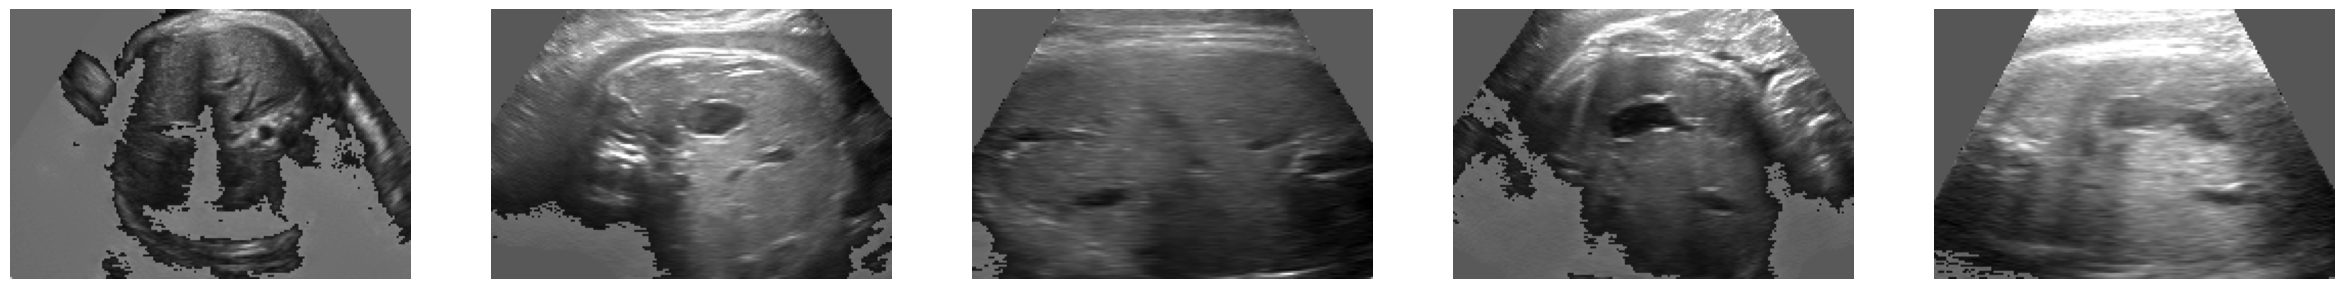

Classes classificadas por subtração: [8, 2, 2, 8, 2]
Classes classificadas com cosseno de similaridade: [1, 0, 0, 0, 0]


In [63]:
#Passo 1: limpeza 
cleaned_imgs = [(clean(img),stru) for img,stru in data_ex]

plot_images(cleaned_imgs, "Imagens limpas:")

#passo 2: Reshape
scalers = [create_reshape(x) for x,_ in cleaned_imgs]
t_imgs = [(transform(cleaned_imgs[i][0],scalers[i]),cleaned_imgs[i][1]) for i in range(len(cleaned_imgs))]
plot_images(t_imgs ,"Imagens após reshape:")

#passo 3: Transformações
r_imgs = [(reduce(t_imgs[i][0]),t_imgs[i][1]) for i in range(len(t_imgs))]
r_b_imgs = [(remove_black(r_imgs[i][0]),r_imgs[i][1]) for i in range(len(r_imgs))]
plot_images(r_b_imgs,"Após transformações:")

#passo 4: Classificação em classes
model_sub  = Model_2('MODEL')
model_cos =  Model_cos('MODEL_c')
classes_sub = [model_sub.get_best_class(data_ex[i][0]) for i in range(len(data_ex))]
classes_cos= [model_cos.get_best_class(data_ex[i][0]) for i in range(len(data_ex))]


print("Classes classificadas por subtração:",classes_sub)
print("Classes classificadas com cosseno de similaridade:",classes_cos)

#### Inferência:

Após a identificação da melhor classe (modelo), são utilizados templates específicos associados aos órgãos para inferir a presença dessas estruturas na imagem.

Modelo que usa Subtração:


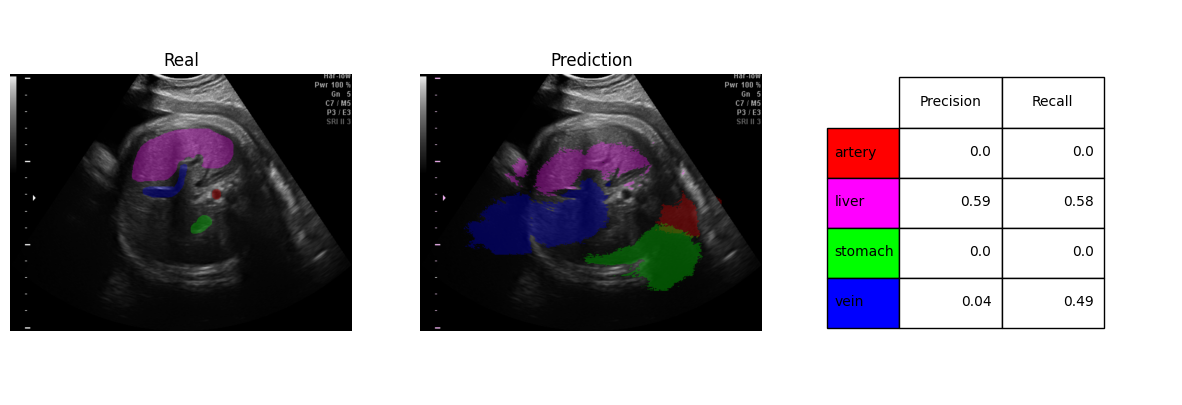

Modelo que usa Cosseno de similaridade:


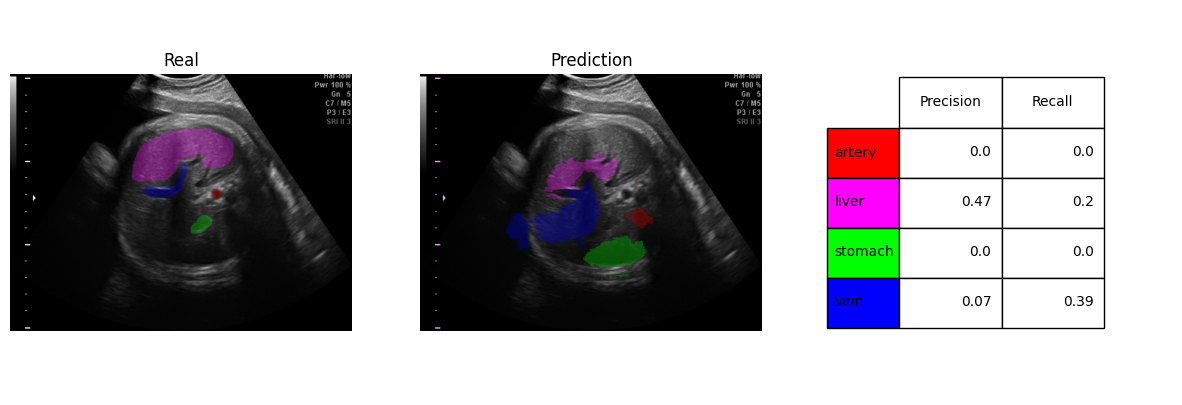

Modelo que usa Subtração:


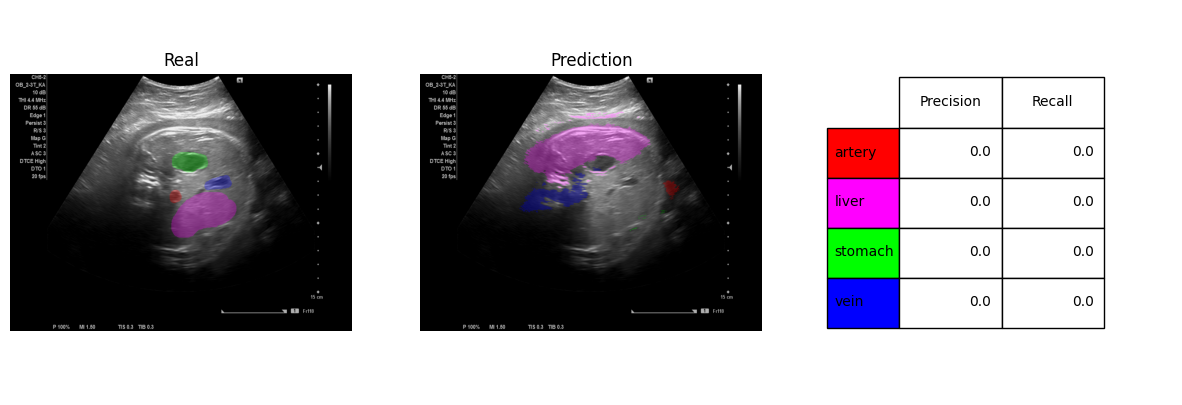

Modelo que usa Cosseno de similaridade:


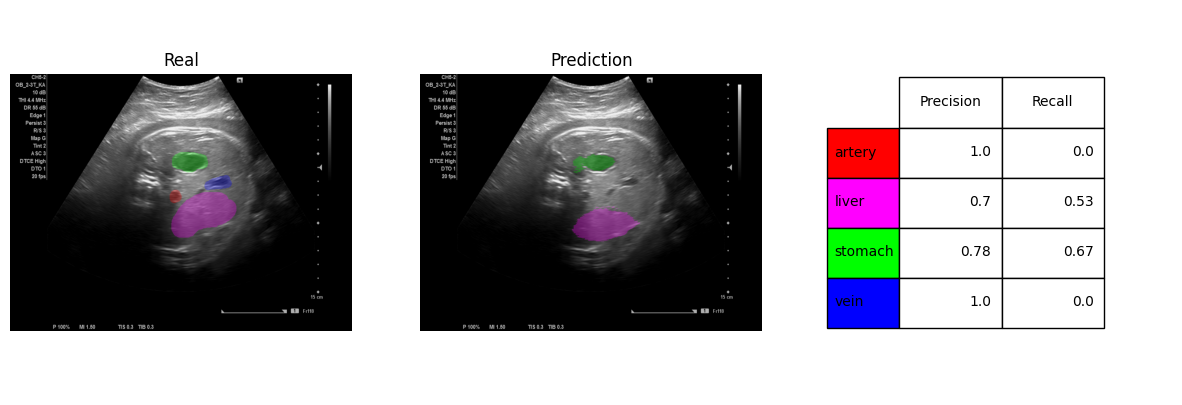

Modelo que usa Subtração:


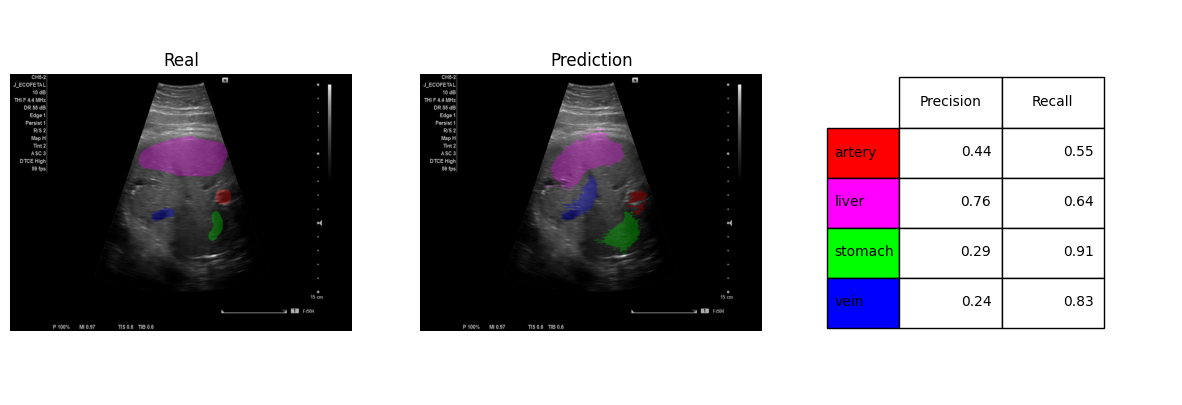

Modelo que usa Cosseno de similaridade:


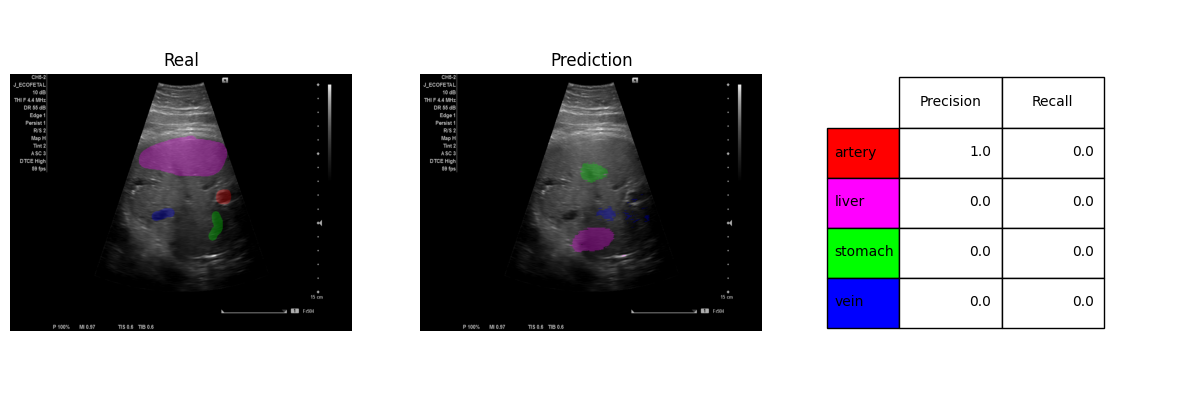

Modelo que usa Subtração:


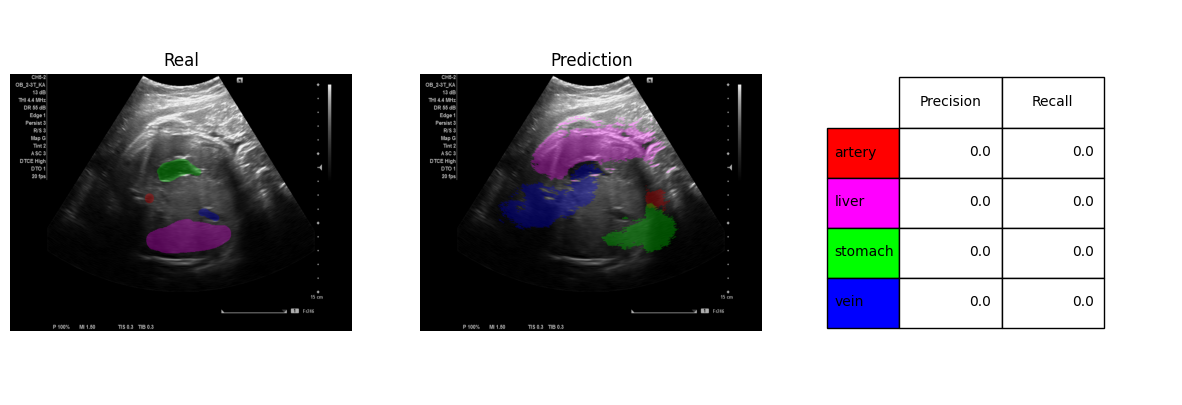

Modelo que usa Cosseno de similaridade:


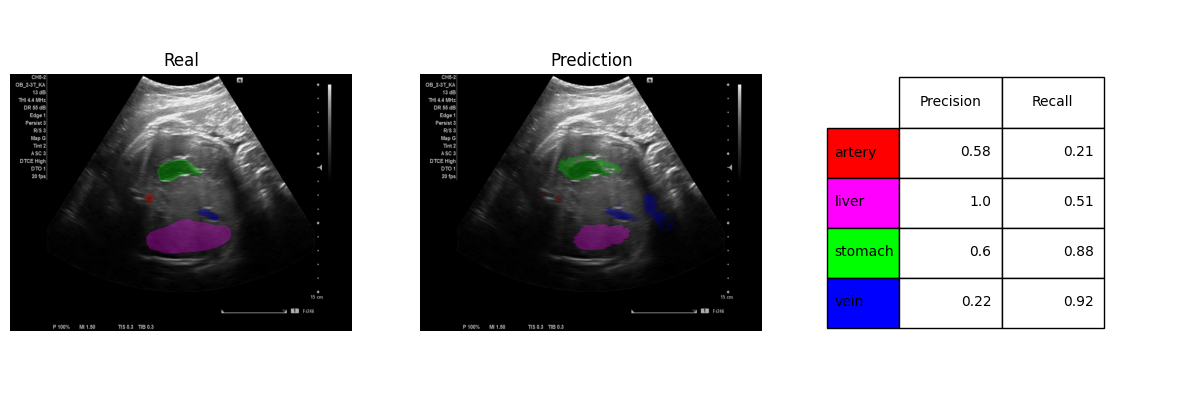

Modelo que usa Subtração:


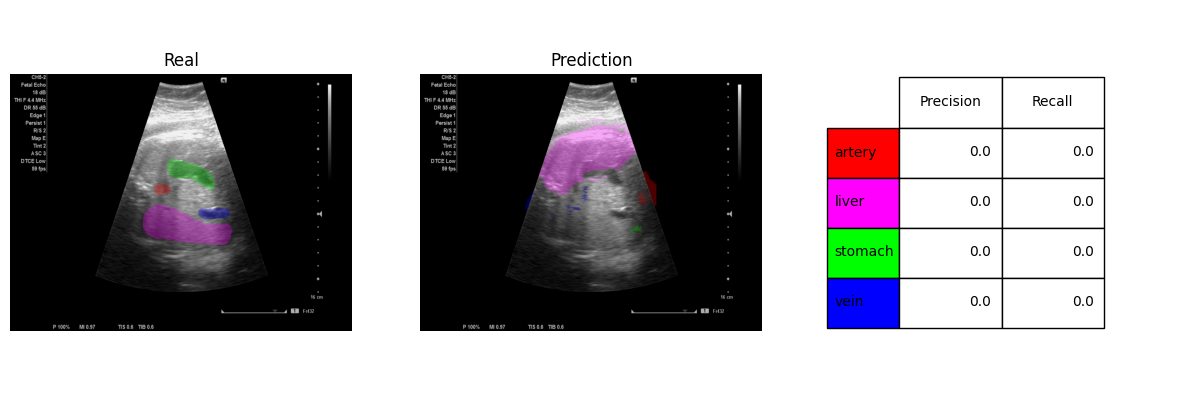

Modelo que usa Cosseno de similaridade:


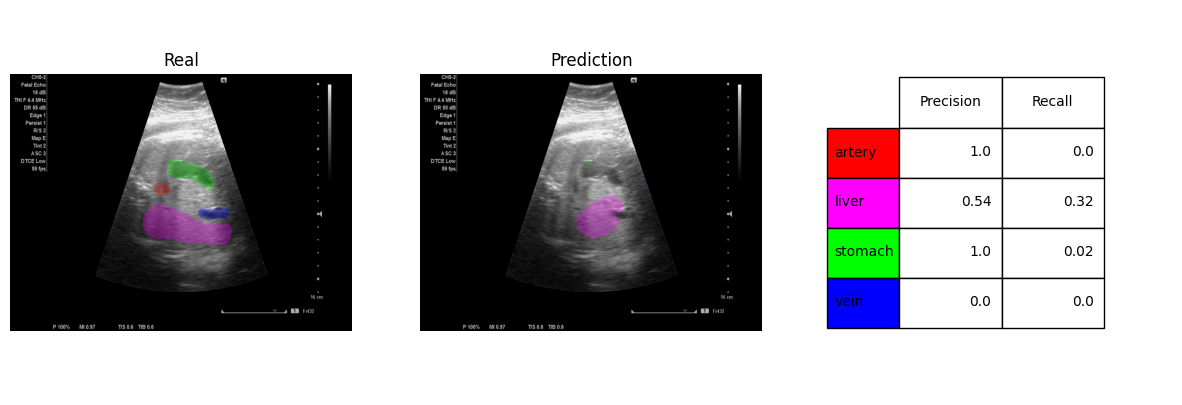

In [64]:
model_sub = Model_2("MODEL_5")
model_cos =Model("MODEL_c_5")
for img,struc in data_ex:

    prediction_sub = model_sub.predict(img)
    prediction_cos = model_cos.predict(img)
    print("Modelo que usa Subtração:")
    plot_pred(img,struc,prediction_sub)
    print("Modelo que usa Cosseno de similaridade:")
    plot_pred(img,struc,prediction_cos)

### Resultados:

         Precision_Model_2  Recall_Model_2  Precision_Model_Cos  \
artery            0.238860        0.026906             0.100121   
liver             0.255087        0.044894             0.326486   
stomach           0.186072        0.214161             0.118339   
vein              0.113443        0.101943             0.134099   

         Recall_Model_Cos  
artery           0.069298  
liver            0.202474  
stomach          0.271111  
vein             0.301846  


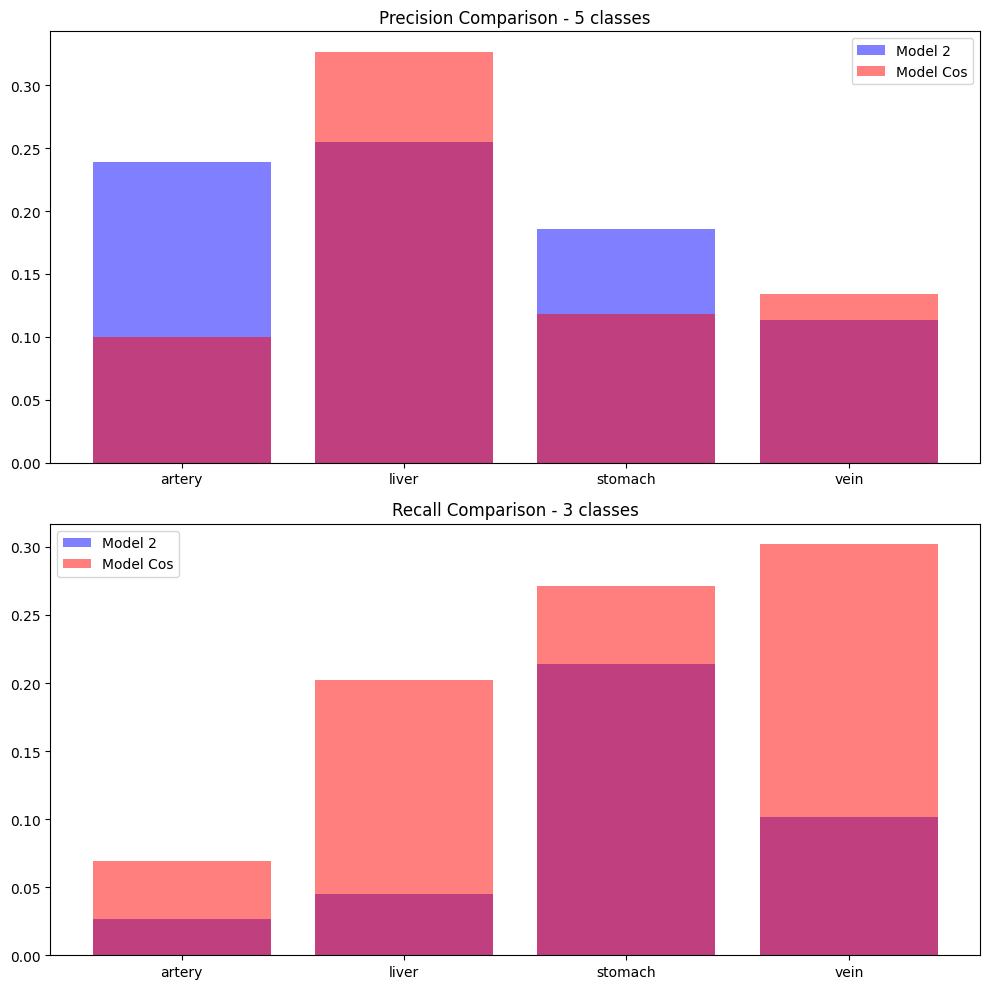

In [29]:


# Definindo os modelos
model_2 = Model_2("MODEL")
model_cos = Model_cos("MODEL_c")

# Inicializando dicionários para armazenar precisão e recall
precision_2 = {org: [] for org in ORGAOS}
recall_2 = {org: [] for org in ORGAOS}
precision_cos = {org: [] for org in ORGAOS}
recall_cos = {org: [] for org in ORGAOS}

# Loop sobre os arquivos de imagem
for i, file in enumerate(data_files):  # todos arquivos
    img, struc = load(file)
    
    # Previsão com o modelo 2
    prediction_2 = model_2.predict(img)
    res_2 = evaluate(struc, prediction_2)
    
    # Previsão com o modelo cos
    prediction_cos = model_cos.predict(img)
    res_cos = evaluate(struc, prediction_cos)
    
    # Armazenando precisão e recall
    for org in ORGAOS:
        precision_2[org].append(res_2[org][0])
        recall_2[org].append(res_2[org][1])
        precision_cos[org].append(res_cos[org][0])
        recall_cos[org].append(res_cos[org][1])
    
    print('Files:', i + 1, end='\r')

# Calculando médias de precisão e recall
m_precision_2 = {org: np.array(precision_2[org]).mean() for org in ORGAOS}
m_recall_2 = {org: np.array(recall_2[org]).mean() for org in ORGAOS}
m_precision_cos = {org: np.array(precision_cos[org]).mean() for org in ORGAOS}
m_recall_cos = {org: np.array(recall_cos[org]).mean() for org in ORGAOS}

# Criando a tabela de resultados
table = pd.DataFrame({
    'Precision_Model_2': m_precision_2.values(),
    'Recall_Model_2': m_recall_2.values(),
    'Precision_Model_Cos': m_precision_cos.values(),
    'Recall_Model_Cos': m_recall_cos.values()
}, index=ORGAOS)

# Exibindo a tabela
print(table)

# Plotando os resultados para visualização
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Precision plot
axes[0].bar(ORGAOS, m_precision_2.values(), color='blue', alpha=0.5, label='Model 2')
axes[0].bar(ORGAOS, m_precision_cos.values(), color='red', alpha=0.5, label='Model Cos')
axes[0].set_title('Precision Comparison - 10 classes')
axes[0].legend()

# Recall plot
axes[1].bar(ORGAOS, m_recall_2.values(), color='blue', alpha=0.5, label='Model 2')
axes[1].bar(ORGAOS, m_recall_cos.values(), color='red', alpha=0.5, label='Model Cos')
axes[1].set_title('Recall Comparison - 10 classes')
axes[1].legend()

plt.tight_layout()
plt.show()



In [15]:

precision = {org:[] for org in ORGAOS}
recall = {org:[] for org in ORGAOS}
conf_matrices_total = {org: np.zeros((2, 2), dtype=int) for org in ORGAOS}  # Supondo binário (2x2)

for i,file in enumerate(data_files[0:20]): #20 fotos
    img,struc = load(file)
    prediction = model.predict(img)
    res = evaluate(struc,prediction)
    conf_mat = conf_matrix(struc,prediction)
    for org in ORGAOS:
        precision[org].append(res[org][0])
        recall[org].append(res[org][1])
        conf_matrices_total[org] += conf_mat[org] 
    print('Files:',i+1,end = '\r')

m_precision = {org:np.array(precision[org]).mean() for org in ORGAOS}
m_recall = {org:np.array(recall[org]).mean() for org in ORGAOS}

table = pd.DataFrame({'Precision':m_precision.values(),'Recall':m_recall.values()},index = ORGAOS)
table

,Precision,Recall
artery,0.222386,0.055594
liver,0.469303,0.223301
stomach,0.091740,0.229448
vein,0.225471,0.253409


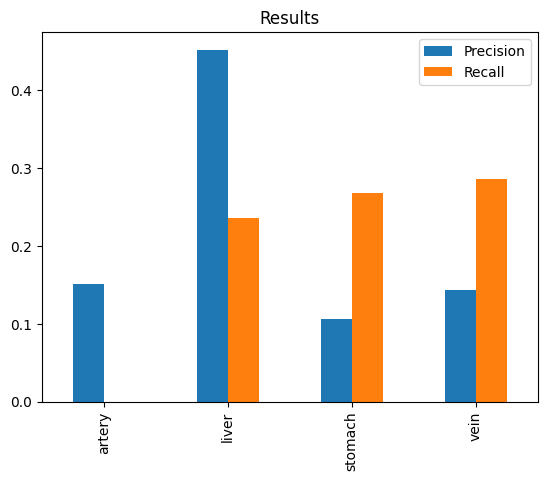

In [13]:
table.plot(kind = 'bar',title = 'Results')
plt.show()

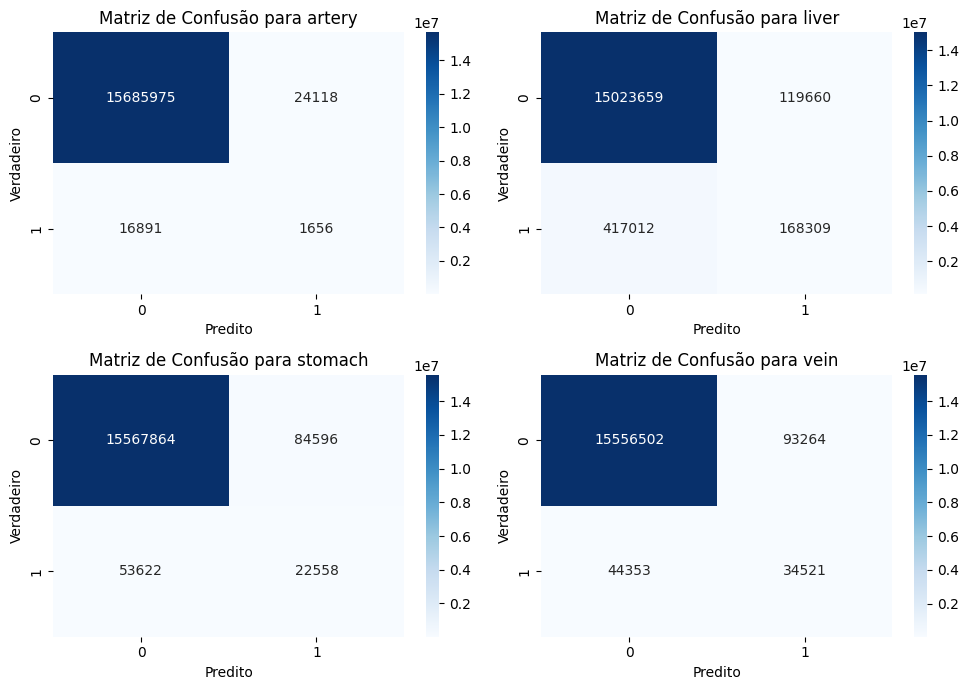

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()  # Para facilitar a iteração


for i, org in enumerate(ORGAOS):
    sns.heatmap(conf_matrices_total[org], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {org}')
    axes[i].set_xlabel('Prediction')
    axes[i].set_ylabel('Truth')



plt.tight_layout()
plt.show()

In [8]:

data_precision = {
    'Model_2_10classes': [0.202932, 0.376306, 0.139283, 0.172008],
    
    'Model_Cos_10classes': [0.146046, 0.392321, 0.127563, 0.169407],
  
    'Model_2_5classes': [0.038524, 0.405927, 0.073138, 0.138374],
    
    'Model_Cos_5classes': [0.291239, 0.428036, 0.153814, 0.217782],
  
    'Model_2_3classes': [0.238860, 0.255087, 0.186072, 0.113443],
   
    'Model_Cos_3classes': [0.100121, 0.326486, 0.118339, 0.134099],
   
}

data_recall = {
    
    'Model_2_10classes': [0.067029, 0.202668, 0.280555, 0.238516],
   
    'Model_Cos_10classes': [0.097127, 0.233192, 0.294468, 0.282075],

    'Model_2_5classes': [0.053589, 0.344574, 0.261184, 0.424411],
   
    'Model_Cos_5classes': [0.057631, 0.234624, 0.288442, 0.280163],

    'Model_2_3classes': [0.026906, 0.044894, 0.214161, 0.101943],
   
    'Model_Cos_3classes': [0.069298, 0.202474, 0.271111, 0.301846]
}

index_classes = ['artery', 'liver', 'stomach', 'vein']

# Criando tabelas de resultados
table_precision = pd.DataFrame(data_precision, index=index_classes)
table_recall = pd.DataFrame(data_recall, index=index_classes)

# Salvando em CSV
table_precision.to_csv('results/precision_data.csv')
table_recall.to_csv('results/recall_data.csv')

In [5]:


# Índices correspondentes às classes
index_classes = ['artery', 'liver', 'stomach', 'vein']

# Criando tabelas de resultados
table_precision = pd.DataFrame(data_precision, index=index_classes)
table_recall = pd.DataFrame(data_recall, index=index_classes)


,Recall_Model_2_10classes,Recall_Model_Cos_10classes,Recall_Model_2_5classes,Recall_Model_Cos_5classes,Recall_Model_2_3classes,Recall_Model_Cos_3classes
artery,0.067029,0.097127,0.053589,0.057631,0.026906,0.069298
liver,0.202668,0.233192,0.344574,0.234624,0.044894,0.202474
stomach,0.280555,0.294468,0.261184,0.288442,0.214161,0.271111
vein,0.238516,0.282075,0.424411,0.280163,0.101943,0.301846


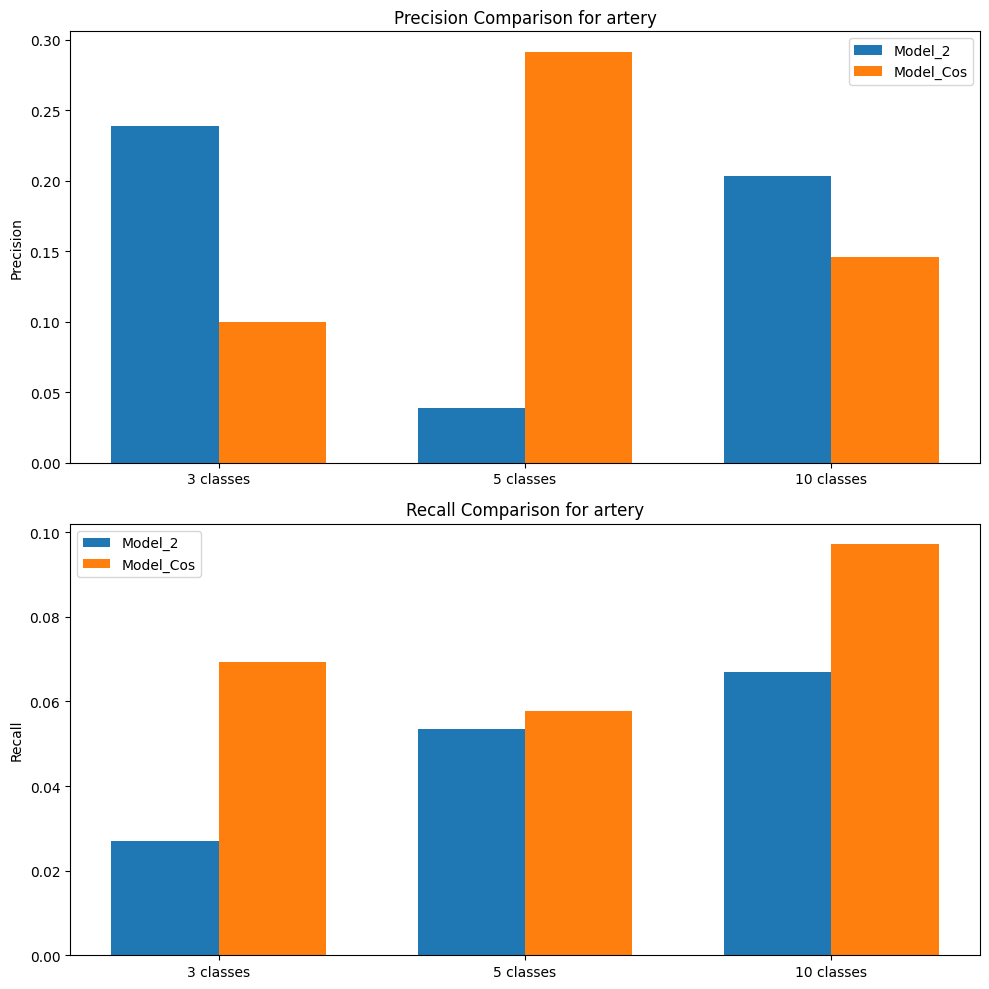

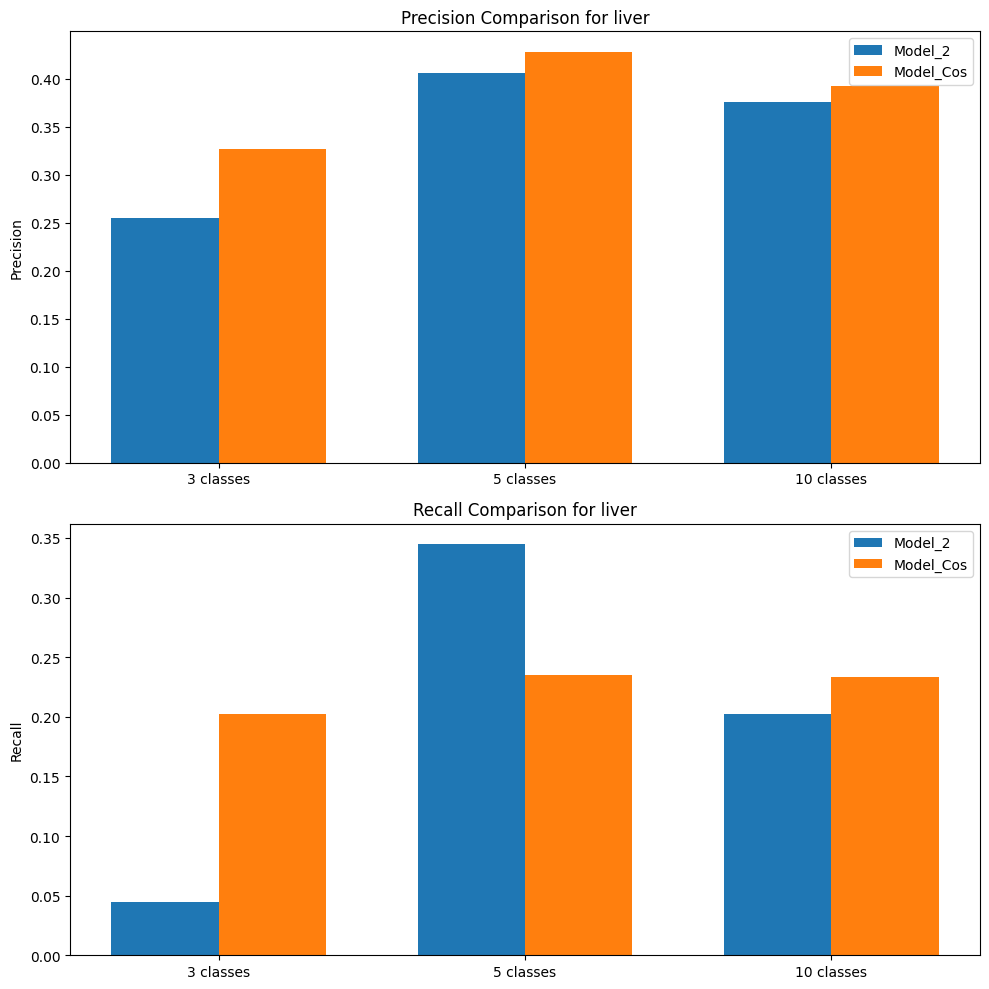

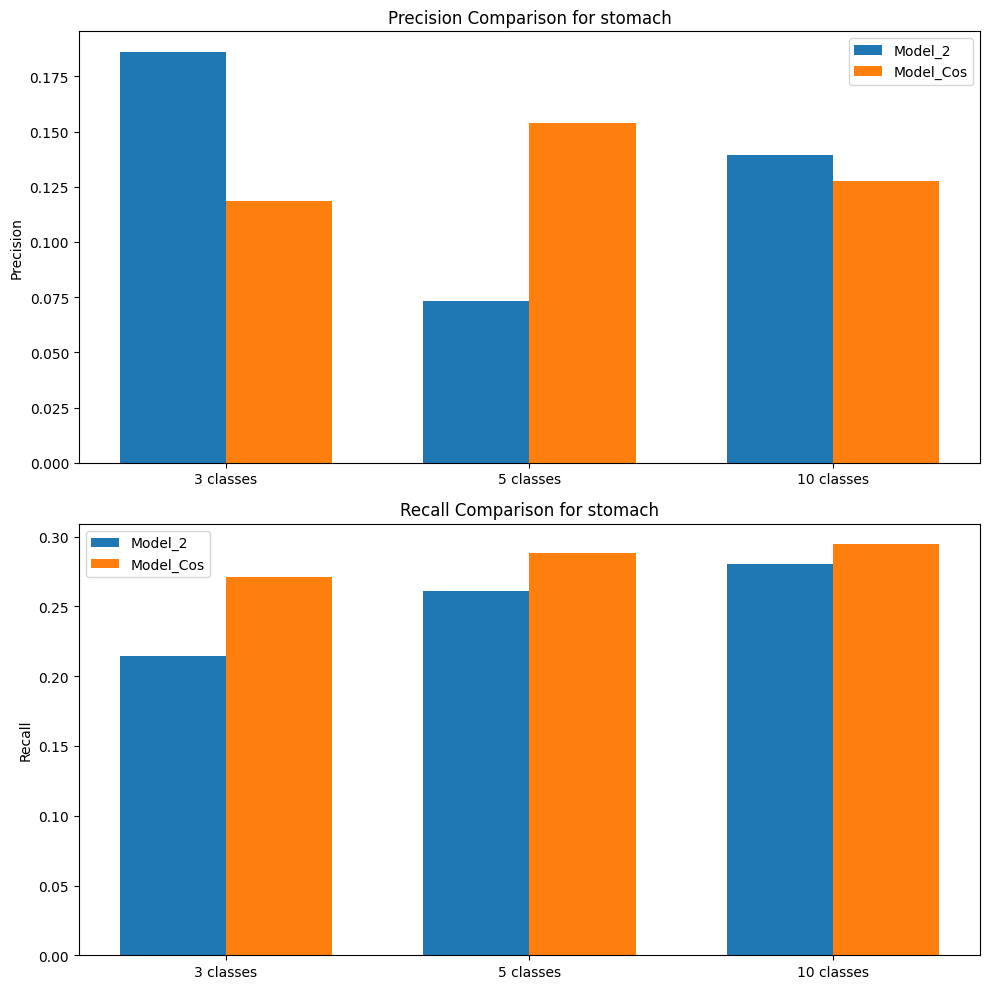

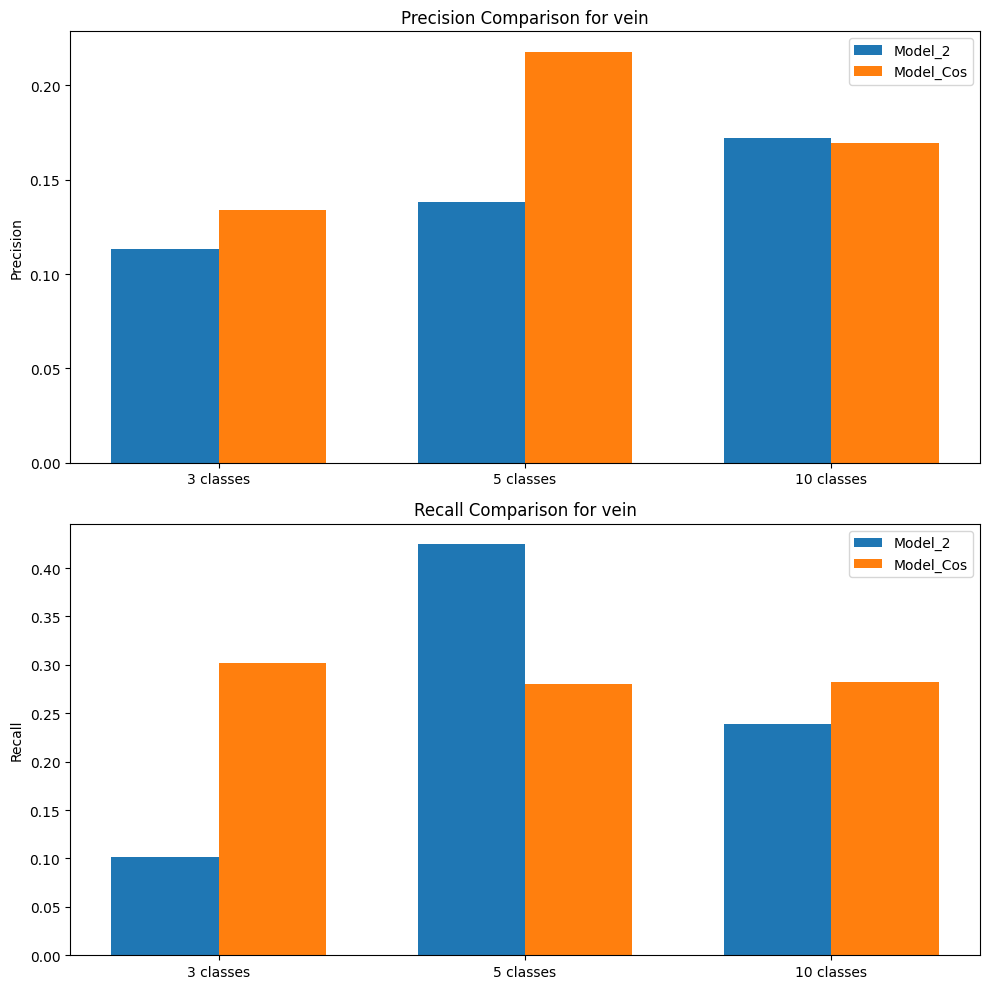

In [6]:
def plot_comparison_for_organ(organ, table_precision, table_recall):
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    num_classes = ['3 classes', '5 classes', '10 classes']
    models = ['Model_2', 'Model_Cos']
    
    # Precisão
    precision_values = [
        [table_precision[f'Precision_{model}_{classes}'][organ] for classes in ['3classes', '5classes', '10classes']]
        for model in models
    ]
    
    # Recall
    recall_values = [
        [table_recall[f'Recall_{model}_{classes}'][organ] for classes in ['3classes', '5classes', '10classes']]
        for model in models
    ]
    
    x = np.arange(len(num_classes))  # Número de classes
    width = 0.35  # Largura das barras
    
    axes[0].bar(x - width/2, precision_values[0], width, label='Model_2')
    axes[0].bar(x + width/2, precision_values[1], width, label='Model_Cos')
    axes[0].set_title(f'Precision Comparison for {organ}')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(num_classes)
    axes[0].set_ylabel('Precision')
    axes[0].legend()
    
    axes[1].bar(x - width/2, recall_values[0], width, label='Model_2')
    axes[1].bar(x + width/2, recall_values[1], width, label='Model_Cos')
    axes[1].set_title(f'Recall Comparison for {organ}')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(num_classes)
    axes[1].set_ylabel('Recall')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Plotando para cada órgão separadamente
for organ in index_classes:
    plot_comparison_for_organ(organ, table_precision, table_recall)